## Dataset used from Kaggle : 
[Link](https://www.kaggle.com/datasets/murtozalikhon/brain-tumor-multimodal-image-ct-and-mri)

In [31]:
import numpy as np
import pandas as pd
import os
base_path = "Dataset/Brain Tumor MRI images"
categories = ["Healthy","Tumor"]
image_paths = []
labels = []
for category in categories:
    category_path = os.path.join(base_path, category)
    for image_name in os.listdir(category_path):
        image_path = os.path.join(category_path, image_name)
        image_paths.append(image_path)
        labels.append(category)

df = pd.DataFrame({
 "image_path": image_paths,
 "label": labels
})
df.head()

,image_path,label
0,Dataset/Brain Tumor MRI images/Healthy/mri_hea...,Healthy
1,Dataset/Brain Tumor MRI images/Healthy/mri_hea...,Healthy
2,Dataset/Brain Tumor MRI images/Healthy/mri_hea...,Healthy
3,Dataset/Brain Tumor MRI images/Healthy/mri_hea...,Healthy
4,Dataset/Brain Tumor MRI images/Healthy/mri_hea...,Healthy


In [32]:
df.tail()

,image_path,label
4995,Dataset/Brain Tumor MRI images/Tumor/tumor (35...,Tumor
4996,Dataset/Brain Tumor MRI images/Tumor/meningiom...,Tumor
4997,Dataset/Brain Tumor MRI images/Tumor/glioma (1...,Tumor
4998,Dataset/Brain Tumor MRI images/Tumor/meningiom...,Tumor
4999,Dataset/Brain Tumor MRI images/Tumor/meningiom...,Tumor


In [33]:
df.shape


(5000, 2)

In [34]:
df.columns

Index(['image_path', 'label'], dtype='object')

In [35]:
df.duplicated().sum()

0

In [36]:
df.isnull().sum()

image_path    0
label         0
dtype: int64

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  5000 non-null   object
 1   label       5000 non-null   object
dtypes: object(2)
memory usage: 78.3+ KB


In [38]:
df['label'].unique()
array=np.array
array(['Healthy', 'Tumor'], dtype=object)
df['label'].value_counts()

label
Tumor      3000
Healthy    2000
Name: count, dtype: int64

/tmp/ipykernel_19288/867187101.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="label", palette="viridis", ax=ax)


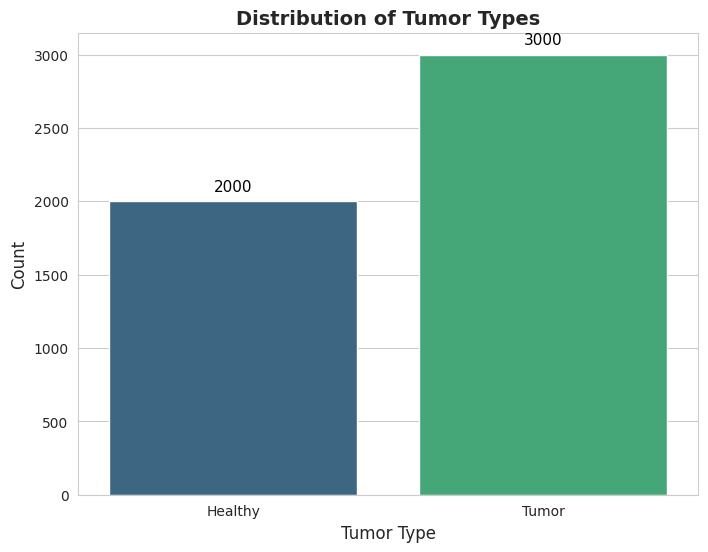

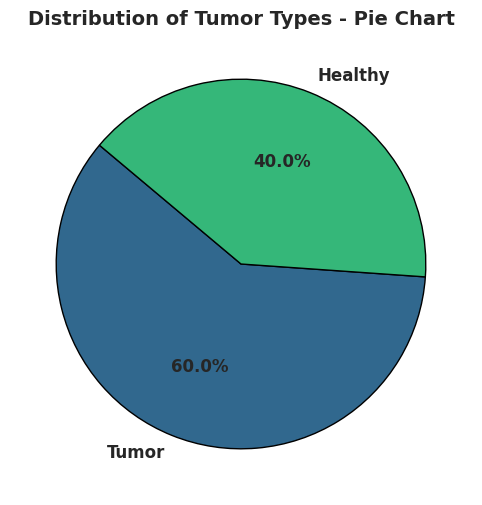

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(8, 6))
sns.countplot(data=df, x="label", palette="viridis", ax=ax)
ax.set_title("Distribution of Tumor Types", fontsize=14, fontweight='bold')
ax.set_xlabel("Tumor Type", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=11, color='black',
                xytext=(0, 5), textcoords='offset points')
plt.show()
label_counts = df["label"].value_counts()
fig, ax = plt.subplots(figsize=(8, 6))
colors = sns.color_palette("viridis", len(label_counts))
ax.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%',
       startangle=140, colors=colors, textprops={'fontsize': 12, 'weight':
                                                 'bold'},
        wedgeprops={'edgecolor': 'black', 'linewidth': 1})
ax.set_title("Distribution of Tumor Types - Pie Chart", fontsize=14,
fontweight='bold')
plt.show()

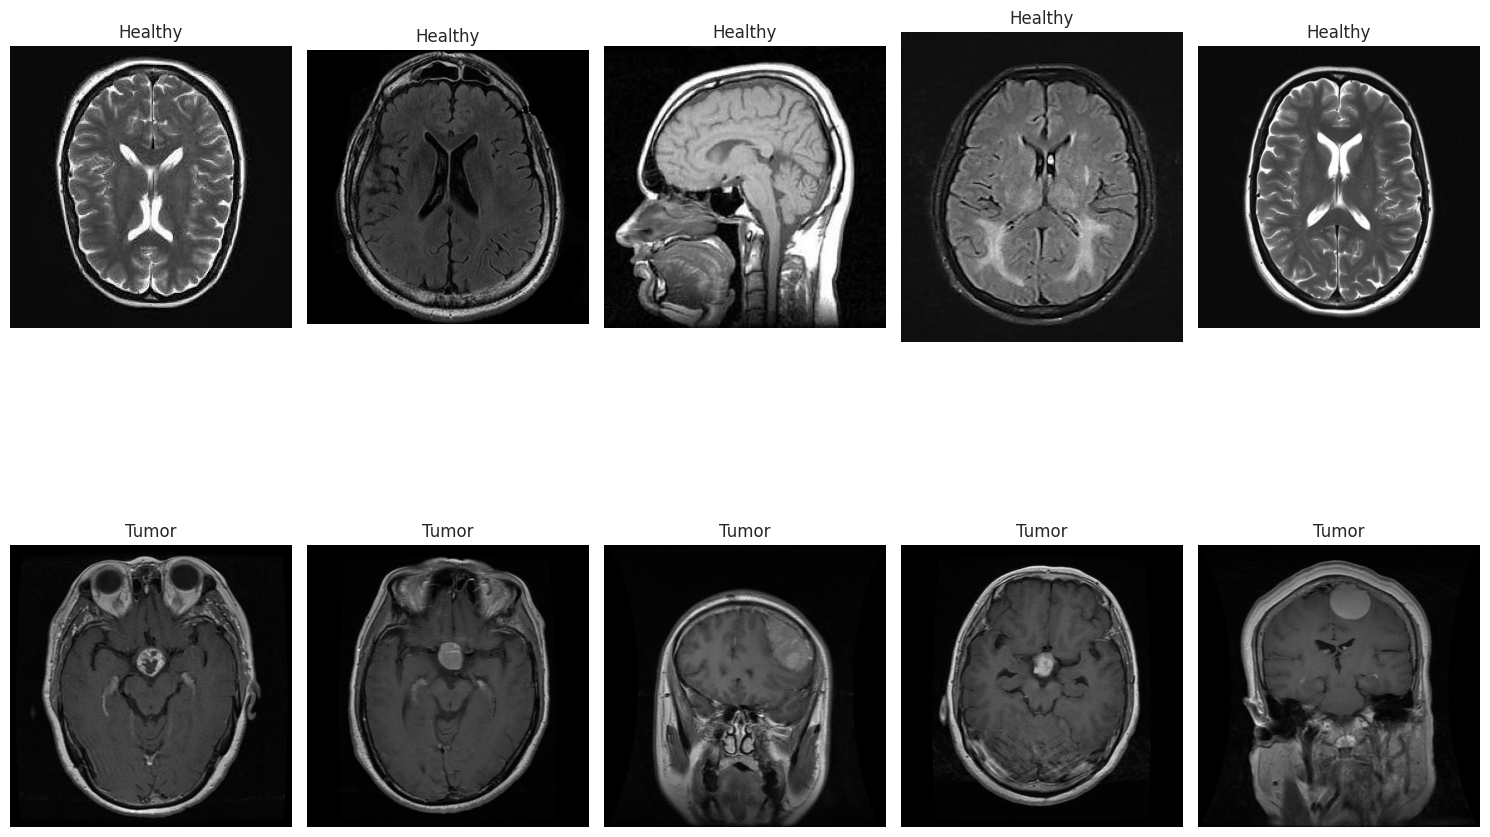

In [40]:
import cv2
num_images = 5
plt.figure(figsize=(15, 12))
for i, category in enumerate(categories):
   category_images = df[df['label'] == category]['image_path'].iloc[:num_images]
   for j, img_path in enumerate(category_images):
     img = cv2.imread(img_path)
     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
     plt.subplot(len(categories), num_images, i * num_images + j + 1)
     plt.imshow(img)
     plt.axis('off')
     plt.title(category)

plt.tight_layout()
plt.show()

In [41]:
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler

label_encoder = LabelEncoder()
df['category_encoded'] = label_encoder.fit_transform(df['label'])
df = df[['image_path', 'category_encoded']]

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(df[['image_path']],
df['category_encoded'])
df_resampled = pd.DataFrame(X_resampled, columns=['image_path'])
df_resampled['category_encoded'] = y_resampled
print("\nClass distribution after oversampling:")
print(df_resampled['category_encoded'].value_counts())


Class distribution after oversampling:
category_encoded
0    3000
1    3000
Name: count, dtype: int64


In [42]:
df_resampled

,image_path,category_encoded
0,Dataset/Brain Tumor MRI images/Healthy/mri_hea...,0
1,Dataset/Brain Tumor MRI images/Healthy/mri_hea...,0
2,Dataset/Brain Tumor MRI images/Healthy/mri_hea...,0
3,Dataset/Brain Tumor MRI images/Healthy/mri_hea...,0
4,Dataset/Brain Tumor MRI images/Healthy/mri_hea...,0
...,...,...
5995,Dataset/Brain Tumor MRI images/Healthy/mri_hea...,0
5996,Dataset/Brain Tumor MRI images/Healthy/mri_hea...,0
5997,Dataset/Brain Tumor MRI images/Healthy/mri_hea...,0
5998,Dataset/Brain Tumor MRI images/Healthy/mri_hea...,0


In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F


class AreaAttentionLayer(nn.Module):
    def __init__(self, in_channels, reduction_ratio: int = 8):
        super(AreaAttentionLayer, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels // reduction_ratio, kernel_size=1)
        self.conv2 = nn.Conv2d(in_channels // reduction_ratio, 1, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm2d(in_channels // reduction_ratio)

    def forward(self, x):
        batch_size, channels, height, width = x.shape
        attention = self.conv1(x)
        attention = self.bn(attention)
        attention = F.relu(attention)
        attention = self.conv2(attention)
        attention = torch.sigmoid(attention)

        return x * attention

class CNNBlock(nn.Module):
    def __init__(self, filters: int, use_attention: bool = True):
        super(CNNBlock, self).__init__()
        self.use_attention = use_attention
        
        if self.use_attention:
            self.area_attention = AreaAttentionLayer(filters)
        
        self.conv = nn.Sequential(
            nn.Conv2d(filters, filters, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(filters),
            nn.ReLU(inplace=True),
            nn.Conv2d(filters, filters, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(filters)
        )
        
        self.shortcut = nn.Identity()

    def forward(self, x):
        identity = x
        
        if self.use_attention:
            x = self.area_attention(x)
        
        x = self.conv(x)
        
        if x.shape[1] != identity.shape[1]:
            identity = nn.Conv2d(identity.shape[1], x.shape[1], kernel_size=1, bias=False)(identity)
            identity = nn.BatchNorm2d(x.shape[1])(identity)
        
        x += identity
        return F.relu(x)

class RESNet(nn.Module):
    def __init__(self, num_classes: int = 1, dropout_rate: float = 0.3, initial_filters: int = 32):  # num_classes=1
        super(RESNet, self).__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(3, initial_filters, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(initial_filters),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        self.blocks = nn.ModuleList([CNNBlock(initial_filters * (2**i)) for i in range(3)])
        
        self.downsamples = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(initial_filters * (2**i), initial_filters * (2**(i+1)), kernel_size=3, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(initial_filters * (2**(i+1))),
                nn.ReLU(inplace=True)
            ) for i in range(2)
        ])
        
        self.final_attention = AreaAttentionLayer(initial_filters * 4)
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(initial_filters * 4, num_classes)  # num_classes=1
    
    def forward(self, x):
        x = self.stem(x)
        
        for i, block in enumerate(self.blocks):
            x = block(x)
            if i < len(self.downsamples):
                x = self.downsamples[i](x)
                x = self.dropout(x)
        
        x = self.final_attention(x)
        x = self.global_pool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x #.squeeze(1)  # حذف بعد اضافی برای سازگاری با BCEWithLogitsLoss



In [44]:
base_path = "Dataset/Brain Tumor MRI images"

# تعریف پردازش‌های اعمال‌شده روی تصاویر
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# لود دیتاست
full_dataset = datasets.ImageFolder(root=base_path, transform=transform)

# تقسیم دیتاست به train و validation
train_size = int(0.8 * len(full_dataset))  # 80% برای آموزش
valid_size = len(full_dataset) - train_size  # 20% برای اعتبارسنجی
train_dataset, valid_dataset = random_split(full_dataset, [train_size, valid_size])

# ساخت DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)

# تعریف مدل
model = RESNet(num_classes=1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device:{device}")
model.to(device)


# تعریف تابع هزینه و بهینه‌ساز
criterion = nn.BCEWithLogitsLoss()
# criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=1e-3)


Device:cuda


In [45]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_loss, correct, total = 0, 0, 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1)  # تبدیل لیبل به شکل (batch_size, 1)

        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        predictions = torch.sigmoid(outputs) > 0.5
        correct += (predictions == labels).sum().item()
        total += labels.size(0)
    
    train_acc = 100 * correct / total
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss/len(train_loader):.4f}, Accuracy: {train_acc:.2f}%")

Epoch 1/10, Loss: 0.4004, Accuracy: 82.88%
Epoch 2/10, Loss: 0.3234, Accuracy: 86.40%
Epoch 3/10, Loss: 0.2702, Accuracy: 88.22%
Epoch 4/10, Loss: 0.2514, Accuracy: 89.33%
Epoch 5/10, Loss: 0.2292, Accuracy: 90.53%
Epoch 6/10, Loss: 0.1897, Accuracy: 92.45%
Epoch 7/10, Loss: 0.1860, Accuracy: 92.75%
Epoch 8/10, Loss: 0.1664, Accuracy: 94.00%
Epoch 9/10, Loss: 0.1522, Accuracy: 93.92%
Epoch 10/10, Loss: 0.1258, Accuracy: 95.62%


In [46]:
model.eval()
valid_loss, correct, total = 0, 0, 0
with torch.no_grad():
    for images, labels in valid_loader:
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
        outputs = model(images)
        loss = criterion(outputs, labels)
        valid_loss += loss.item()
        predictions = torch.sigmoid(outputs) > 0.5
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

valid_acc = 100 * correct / total
print(f"Validation Loss: {valid_loss/len(valid_loader):.4f}, Accuracy: {valid_acc:.2f}%")

Validation Loss: 0.1069, Accuracy: 96.50%


In [47]:
import matplotlib.pyplot as plt

def plot_history(train_losses, val_losses, train_accs, val_accs):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.show()


In [48]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predictions = (torch.sigmoid(outputs) > 0.5).cpu().numpy().astype(int).flatten()
            all_preds.extend(predictions)
            all_labels.extend(labels.cpu().numpy().astype(int).flatten())

    # نمایش Confusion Matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Non Tumor", "Tumor"], yticklabels=["Non Tumor", "Tumor"])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    # نمایش Classification Report
    print("Classification Report:\n", classification_report(all_labels, all_preds))

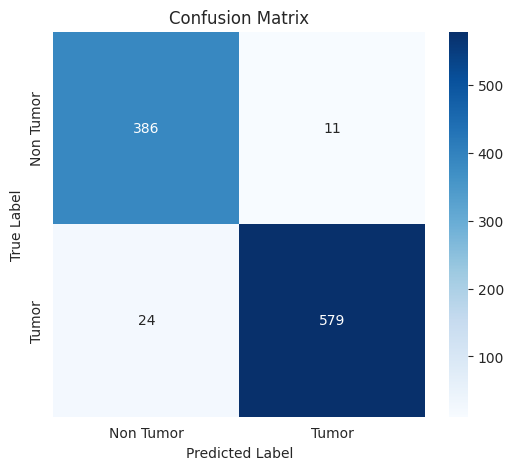

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.97      0.96       397
           1       0.98      0.96      0.97       603

    accuracy                           0.96      1000
   macro avg       0.96      0.97      0.96      1000
weighted avg       0.97      0.96      0.97      1000



In [49]:
evaluate_model(model, valid_loader)